# Imports

In [142]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
# from tensorflow_addons.losses import pinball_loss
from tensorflow import function as tf_fun
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil, floor
import pandas as pd
from math import ceil
from tqdm.notebook import trange
import seaborn as sns

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt

from time import perf_counter
from scipy.stats import norm
from matplotlib import ticker

from importlib import reload

from numpy.random import seed   
from tensorflow.random import set_seed as tf_seed

from copy import deepcopy

tf_seed(1234) ; seed(1234)

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

# Input Settings

In [143]:
S0      = 100
K       = 100
r       = .08
sigma   = 0.15
T       = 1.0

N_paths = 3_000 
dt      = 1/365

rebalancing_frequency = 1/52
OPTION_TYPE = 'CALL' # 'CALL' OR 'PUT'

In [144]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

$S(T)$ is modeled as GBM with $\sigma, r$ as constants
$$
dS(t) = S(t)(rdt + \sigma\sqrt{dt}Z) 
$$
Where, $Z \sim N(0,1)$

Therefore,
$$
S(t+dt) = S(t)exp\{(r+\frac{1}{2}\sigma^2)dt + \sigma\sqrt{dt}Z\}
$$

Paths: 4,096
Number of steps: 366 
dt         = 0.003 year
----------------------------------------------------------------
Time to simulate: 0.099sec
mean S(T)  = 108.327487
S0e^(r*T)  = 108.328707 
Diff       = -0.001220


[]

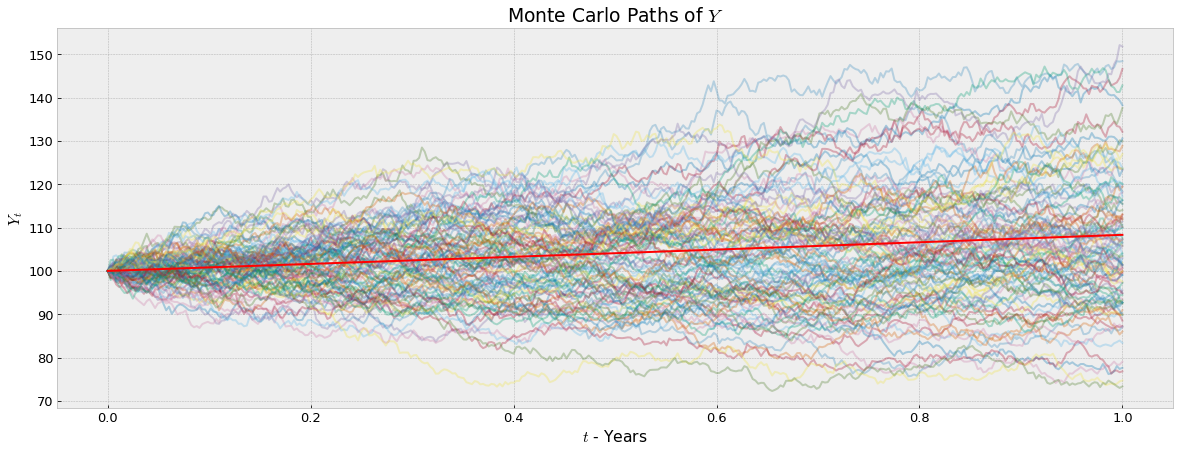

In [145]:
n_paths      = ceil(np.log2(N_paths)) ; print(f'Paths: {2**n_paths:,.0f}')# for both Y and N
n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')
ADUSTMENT_FACTOR = S0

timer=perf_counter()

""" Simulate Fund Price """
W1      = sobol_norm(n_paths, d=n_time_steps, seed=1235)
S_paths = np.empty((2**n_paths, n_time_steps))
S_paths[:,0] = log(S0)

print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    #simulate the log of the stock
    S_paths[:,t] = S_paths[:,t-1] + ((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*W1[:,t])

S_paths = np.exp(S_paths)

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, S_paths.shape)

print(f'Time to simulate: {perf_counter()-timer:.3f}sec')
print(f'mean S(T)  = {np.nanmean(S_paths[:,-1]):.6f}')
print(f'S0e^(r*T)  = {S0*np.exp(r*T):.6f} \nDiff       = {np.nanmean(S_paths[:,-1])-S0*np.exp(r*T):.6f}')

rdf = pd.DataFrame(S_paths.T, index=(np.linspace(0,T, n_time_steps)))
ax = rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y_t$', xlabel=r'$t$ - Years', title=r'Monte Carlo Paths of $Y$') 
ax.plot(np.linspace(0,T, n_time_steps), S0*np.exp(r*np.linspace(0,T, n_time_steps)), c='r') ; plt.plot()


In [146]:
""" Change the frequency of S(T) to the frequency of the rebalancing """
# print(f'Y_paths.shape = {Y_paths.shape}')
reduction       = floor((n_time_steps-1)/(T/rebalancing_frequency))   ; print(f'reduction = {reduction}')
S_paths         = S_paths[:, slice(0, None, reduction)]
B               = B[:, slice(0, None, reduction)]
n_time_steps    = ceil(n_time_steps/reduction) ; dt = rebalancing_frequency

print('Check if values are correct:')
S_paths[:,-1].mean(), dt, S_paths.shape, n_time_steps

reduction = 7
Check if values are correct:


(108.30487063199344, 0.019230769230769232, (4096, 53), 53)

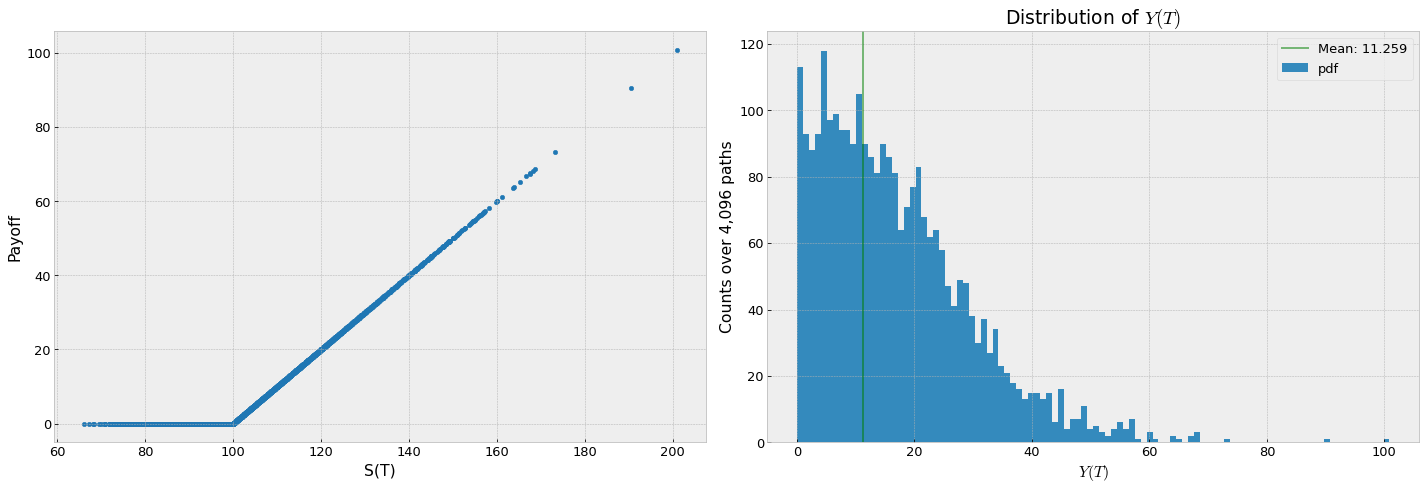

EUROPEAN CALL OPTION:
Prob S(T) < K = 32.93%


,Payoff
mean,11.258669
std,12.972705
min,0.000000
10%,0.000000
50%,7.036041
90%,29.452093
95%,36.411599
99%,51.930359
max,100.871992


In [147]:
""" Payoff vs S(T), Payoff Histogram """
fig, (ax1, ax2) = plt.subplots(1,2)

if OPTION_TYPE == "CALL": payoff = np.maximum(S_paths[:,-1] - K, 0)
if OPTION_TYPE == "PUT" : payoff = np.maximum(K - S_paths[:,-1], 0)

# Payoff Histogram plot
payoff_df = pd.DataFrame({'Payoff' :payoff , 'S(T)': S_paths[:,-1]})
payoff_df.plot.scatter(x='S(T)', y='Payoff', ax=ax1, c='tab:blue')

# Payoff Histogram plot
payoff_df['Payoff'].where(payoff_df['Payoff']>0).hist(bins=100, ax=ax2) ; ax2.set_title(r'Distribution of $Y(T)$')
ax2.axvline(payoff_df['Payoff'].mean(), color='g', linestyle='-', alpha=.5)
ax2.legend([f"Mean: {payoff_df['Payoff'].mean():.3f}", 'pdf'])
ax2.set_xlabel(r'$Y(T)$') ; ax2.set_ylabel(f'Counts over {S_paths.shape[0]:,} paths')

fig.tight_layout() ; plt.show()

if OPTION_TYPE == "CALL":
    prob_out_of_money = np.where(payoff_df['Payoff'] > 0, 0,1).mean()
    print(f'EUROPEAN CALL OPTION:\nProb S(T) < K = {prob_out_of_money*100:.2f}%')
if OPTION_TYPE == "PUT":
    prob_out_of_money = np.where(payoff_df['Payoff'] > 0, 1,0).mean()
    print(f'EUROPEAN PUT OPTION:\nProb S(T) < K = {prob_out_of_money*100:.2f}%')
payoff_df[['Payoff']].describe(percentiles=[.1,.9,.95,.99])[1:]

# Replicating Portfolio with Neural Networks

In [148]:
def get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values, Y_t, B_t):
    layer_output1=model1.get_layer('Phi_Psi').output
    pw_model1 = Model(inputs=[model1.input], outputs=[layer_output1])

    linear_layer_output1 = pw_model1.predict(X0)

    # layer_output2 = model2.get_layer('Phi_Psi').output
    # pw_model2 = Model(inputs=[model2.input], outputs=[layer_output2])

    # linear_layer_output2 = pw_model2.predict(X0)

    phi = linear_layer_output1[:,0] #+ cost_of_capital * (linear_layer_output1[:,0] - linear_layer_output2[:,0])
    psi = linear_layer_output1[:,1] #+ cost_of_capital * (linear_layer_output1[:,1] - linear_layer_output2[:,1])

    for f  in phi: Phi_Psi_HV.append([f,  t_i*dt, 'Phi'])
    for ps in psi: Phi_Psi_HV.append([ps, t_i*dt, 'Psi'])

    VaR = values - phi * Y_t - psi * B_t

    print(f'VaR: {np.quantile(VaR, .98):4f} (98%),  {np.quantile(VaR, .99):4f} (99%)')
    for var in VaR: VaR_HV.append([var, (t_i+1)*dt])
    
    return Phi_Psi_HV, VaR_HV


def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

@tf_fun
def quantile_loss(y, y_p):
        QUANTILE = .99
        e = y-y_p
        return keras.backend.mean(keras.backend.maximum(QUANTILE*e, (QUANTILE-1)*e))

lr_scheduler    = keras.callbacks.LearningRateScheduler(scheduler)
quantile_loss_f = lambda y, y_p : quantile_loss(y, y_p)

In [171]:
cost_of_capital = .1 
ADJUSTMENT_FACTOR = S0

In [172]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.1, seed=1234)
const_initalizer = keras.initializers.RandomNormal(mean=[payoff.mean()/ADJUSTMENT_FACTOR], stddev=0.0, seed=1234)

# model 1
Input_S_N = keras.Input(shape=(1,), name='input: S_{t}') 
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N)
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
phi = keras.layers.Dense(1, activation='linear', name='Phi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)
psi = 1 - phi
holdings = keras.layers.Concatenate(axis=1, name='Phi_Psi')([phi, psi])

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model1 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_MSE")

#model2
Input_S_N2 = keras.Input(shape=(1,), name='input: S_{t}') 
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N2)
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x2)
holdings2 = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x2)

prices_12 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out2    = keras.layers.Dot(axes = 1, name='V_t')([holdings2, prices_12]) 

model2 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_Q99")
model1.summary()

Model: "Replicating_Portfolio_MSE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input: S_{t} (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
LeakyReLU_1 (Dense)             (None, 8)            16          input: S_{t}[0][0]               
__________________________________________________________________________________________________
LeakyReLU_2 (Dense)             (None, 8)            72          LeakyReLU_1[0][0]                
__________________________________________________________________________________________________
Phi (Dense)                     (None, 1)            9           LeakyReLU_2[0][0]                
__________________________________________________________________________

In [173]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'mse', run_eagerly=False, 
              metrics=["mae", "mape"])
model2.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = quantile_loss_f, run_eagerly=False, 
              metrics=["mae", "mape"])

values          = np.empty_like(S_paths)
values[:,-1]    = payoff / ADJUSTMENT_FACTOR
E_payoff        = (values[:,-1]).mean()

""" Calculate: Payoff for Options """
Flag = True ; its = 0
Errors      = np.zeros((1,2))
P_E_Values  = np.ones((1,2)) * values[:,-1].mean()
VaR_HV      = []
Phi_Psi_HV  = []
for t_i in trange(n_time_steps-2, -1, -1):
    print(f'\n>> S_({(t_i+1)*dt:.2f}) = {S_paths[:,t_i+1].mean():.3f}')
    _S_t  = S_paths[:,t_i]      / ADJUSTMENT_FACTOR
    _B_t  = B[:,t_i]            / ADJUSTMENT_FACTOR
    _S_t1 = S_paths[:,t_i+1]    / ADJUSTMENT_FACTOR
    _B_t1 = B[:,t_i+1]          / ADJUSTMENT_FACTOR

    X0 = [_S_t, np.stack((_S_t, _B_t), axis=-1)]
    X1 = [_S_t, np.stack((_S_t1, _B_t1), axis=-1)]

    epochs = 500
    if Flag :
        # print(f'V.mean: {values[:,-1].mean():.3f}\nP.mean: {model2.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f} \n**These 2 values need to be very close**') ; break
        callabacks = [lr_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]
    else : 
        epochs = 100 
        callabacks = [callback]

    model1.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=1, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
    g_t  = model1.predict(X0, verbose=0, batch_size=512).squeeze()

    Errors = np.append(Errors, np.array(model1.evaluate(X1, values[:,t_i+1], batch_size=512)[1:]).reshape(1,2), axis=0)
    
    # model2.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)    
    # h_t  = model2.predict(X0, verbose=0, batch_size=512).squeeze()

    values[:,t_i] = g_t #+ cost_of_capital*(h_t - g_t)

    """ Update phi-psi and VaR """
    Phi_Psi_HV, VaR_HV = get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values[:,t_i+1], _S_t1, _B_t1)

    its += 1 ; Flag = False 
    P_E_Values = np.append(P_E_Values, np.array([values[:,t_i].mean(), E_payoff*np.exp(-r*dt*its)]).reshape(1,2), axis=0)


  0%|          | 0/52 [00:00<?, ?it/s]


>> S_(1.00) = 108.305
Epoch 1/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0129 - mae: 0.0946 - mape: 36768660.0000
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0119 - mae: 0.0911 - mape: 35303664.0000
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0086 - mae: 0.0782 - mape: 30017936.0000
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0032 - mae: 0.0463 - mape: 15483785.0000
Epoch 5/500
8/8 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0249 - mape: 10156210.0000
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0010 - mae: 0.0241 - mape: 10571562.0000
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 7.6378e-04 - mae: 0.0224 - mape: 7575671.5000
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 6.8315e-04 - mae: 0.0213 - mape: 7014081.0000
Epoch 9/500
8/8 [==============================] - 0s 7ms/

# Residuals - VaR

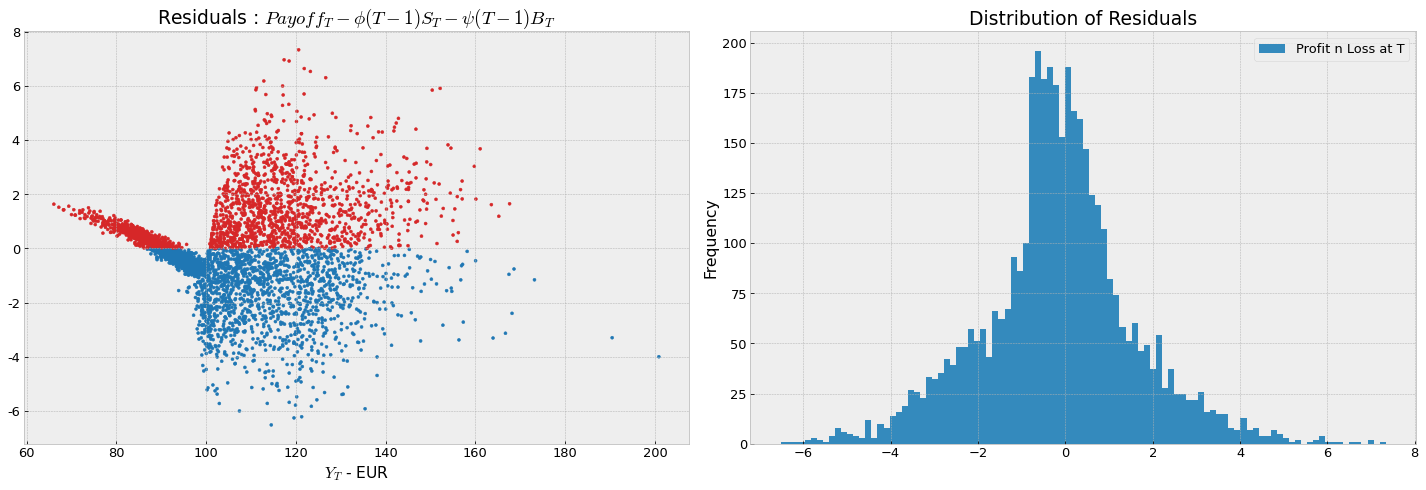

,Profit n Loss at T
count,4096.000000
mean,-0.167534
std,1.750428
min,-6.518394
25%,-1.033364
50%,-0.181711
75%,0.744554
max,7.335386


In [174]:
VaR_HV_df = pd.DataFrame(np.array(VaR_HV)[:,0], index=np.array(VaR_HV)[:,1], columns=['VaR']) * ADJUSTMENT_FACTOR
residuals = VaR_HV_df.loc[T].rename(columns={'VaR':'Profit n Loss at T'})
c = ['tab:red' if r else 'tab:blue' for r in residuals.values  > 0]

fig, (ax1, ax2) = plt.subplots(1,2)
# Residuals over S(T)
ax1.scatter(S_paths[:,-1], residuals.values , color=c, marker='.')
ax1.set_xlabel(r'$Y_{T}$ - EUR'), plt.ylabel('Residuals - EUR')
ax1.set_title(r'Residuals : $Payoff_T - \phi(T-1)S_T - \psi(T-1)B_T$')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Histogram of Residuals
residuals.plot(kind='hist', bins=100, title='Distribution of Residuals', ax=ax2)
fig.tight_layout() ; plt.show()
residuals.describe()

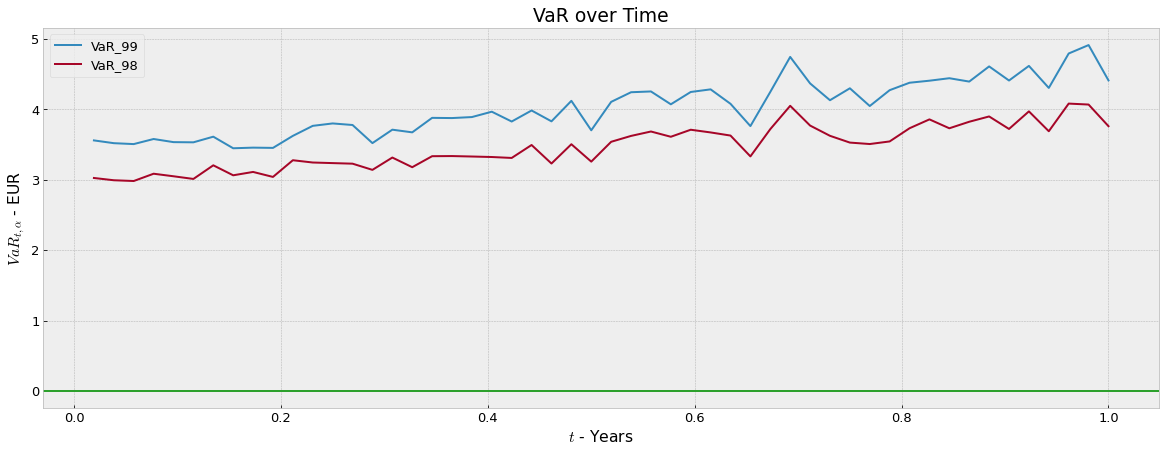

Overall VaR(98.5%) = 3.72 EUR
Overall VaR(99.0%) = 4.05 EUR
Overall VaR(99.5%) = 4.59 EUR


In [175]:
ax = VaR_HV_df.groupby(level=0).aggregate(
    VaR_99=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .99)),
    VaR_98=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .98)),
    ).plot(title=r'VaR over Time', xlabel=r'$t$ - Years', ylabel=r'$VaR_{t,\alpha}$ - EUR')
ax.axhline(0, color='tab:green') ; plt.show()
print(f'Overall VaR(98.5%) = {np.quantile(VaR_HV_df.values, .985):.2f} EUR')
print(f'Overall VaR(99.0%) = {np.quantile(VaR_HV_df.values, .99):.2f} EUR')
print(f'Overall VaR(99.5%) = {np.quantile(VaR_HV_df.values, .995):.2f} EUR')

# Hedging Values

Phi t=0 : 0.10456 Stocks
Psi t=0 : 0.89544 Bonds


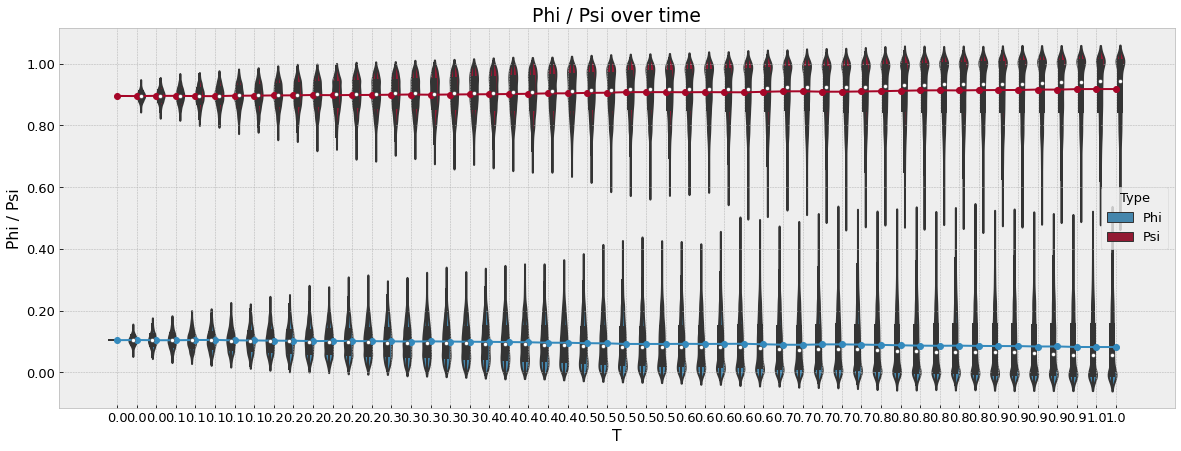

In [176]:
index = np.linspace(0, T, n_time_steps-1, endpoint = False)[::-1]
phi_psi_df = pd.DataFrame(Phi_Psi_HV, columns=['Value', 'T', 'Type'])
# phi_psi_df.Value *= ADJUSTMENT_FACTOR 

ax = sns.violinplot(data=phi_psi_df, x="T", y="Value", hue="Type", dodge=1, cut=True)
ax.set_xticklabels([f'{x:,.1f}'for x in index][::-1])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))

_ppg = phi_psi_df.groupby(['T', 'Type']).agg('mean')

title = 'Distribution of Phi/Psi over time'
phidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Phi'].groupby('T').mean().rename(columns={'Value':'Mean Phi'})['Mean Phi']
psidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Psi'].groupby('T').mean().rename(columns={'Value':'Mean Psi'})['Mean Psi']
phidf.index = range(0, phidf.shape[0]) ; psidf.index = range(0, psidf.shape[0])
phidf.plot(marker='o', ax=ax) ; psidf.plot(marker='o', ax=ax) ; 
ax.set_ylabel('Phi / Psi') ; ax.set_title('Phi / Psi over time') #; ax.set_xlabel('T - Years')

print(f'Phi t=0 : {_ppg.loc[(0, "Phi")].mean():,.5f} Stocks')
print(f'Psi t=0 : {_ppg.loc[(0, "Psi")].mean():,.5f} Bonds')

# _ppg

# Hedging Values

ADJUSTED 
--------------------------------------------
Value at t_0 (Replicating-P)  = 11.352
Discounted Eq[V(T)]           = 10.479
 Difference                   = 0.873 : 8.329%


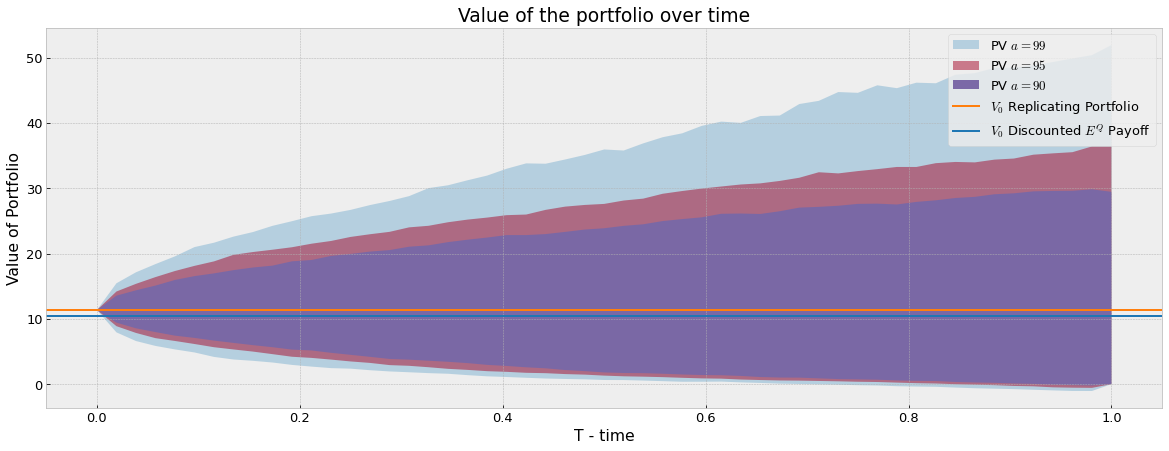

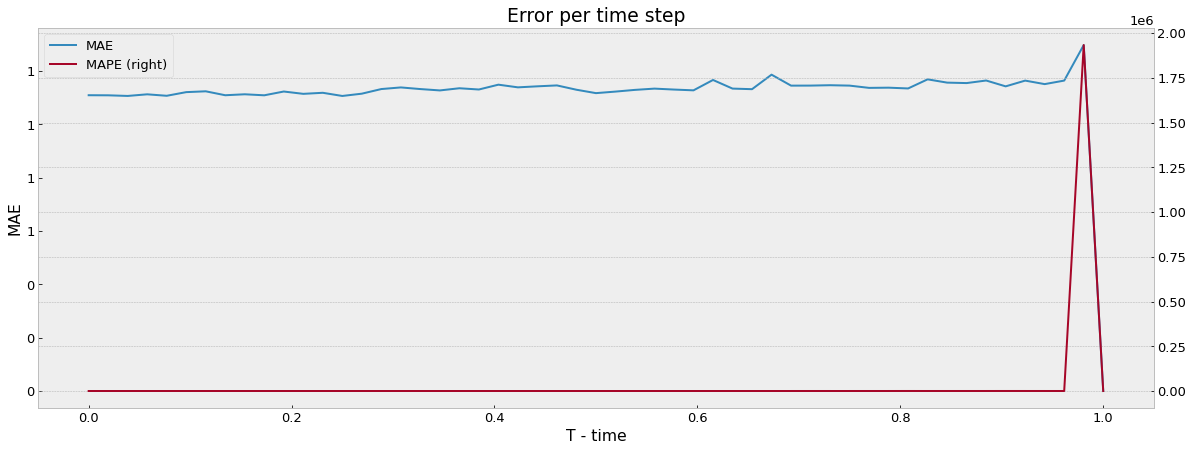

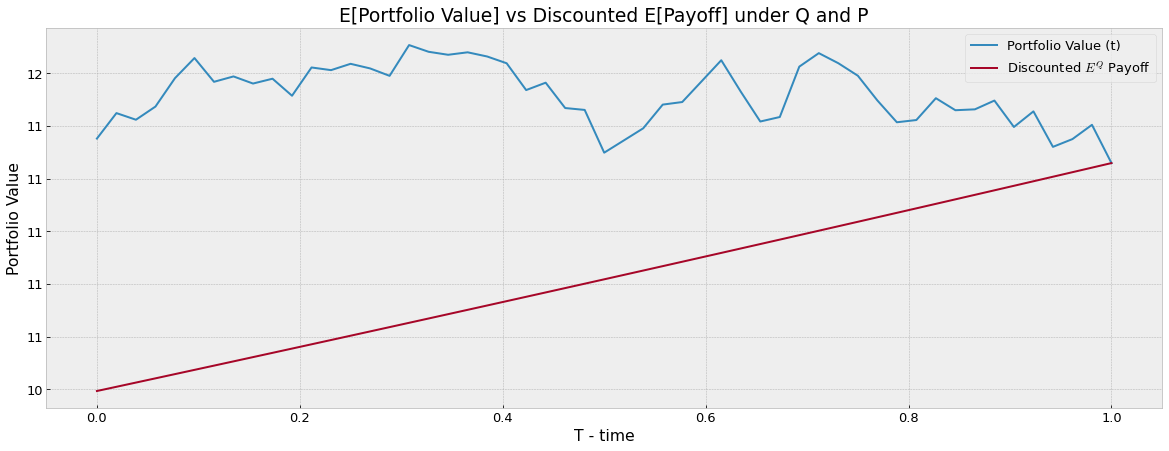

In [177]:
V0_RP = values[:,0].mean() * ADJUSTMENT_FACTOR
V_T   = values[:,0] * ADJUSTMENT_FACTOR

qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0) * ADJUSTMENT_FACTOR
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
plt.ticklabel_format(style='plain', useLocale=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.axhline(V0_RP, color='tab:orange')
ax.axhline(V_T.mean() * np.exp(-r*T), color='tab:blue')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Discounted $E^Q$ Payoff'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print('ADJUSTED \n--------------------------------------------')
print(f'Value at t_0 (Replicating-P)  = {V0_RP:,.3f}')
print(f'Discounted Eq[V(T)]           = {V_T.mean() * np.exp(-r*T):,.3f}')
print(f' Difference                   = {V0_RP - V_T.mean() * np.exp(-r*T):,.3f} : {(V0_RP - V_T.mean() * np.exp(-r*T))/(V_T.mean() * np.exp(-r*T)) * 100:,.3f}%')

Errors_df = pd.DataFrame(np.array(Errors[::-1]), index=t, columns=['MAE', 'MAPE'])
Errors_df['MAE'] = Errors_df['MAE'] * ADJUSTMENT_FACTOR
ax = Errors_df.plot(legend=True, title='Error per time step', ylabel='MAE', secondary_y=['MAPE'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

E_Port_Values_df = pd.DataFrame(np.array(P_E_Values[::-1]), index=t, columns=['Portfolio Value (t)', r'Discounted $E^Q$ Payoff']) * ADJUSTMENT_FACTOR
ax = E_Port_Values_df.plot(legend=True, title='E[Portfolio Value] vs Discounted E[Payoff] under Q and P', ylabel='Portfolio Value')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

plt.show()